In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats.mstats import mquantiles

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Import custom quantile regression models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import qr_models as qr

## Data set

In this workbook, we will use a real data set about car fuel efficiency.
This dataset was taken from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/auto+mpg).


In [3]:
import pandas as pd

# Download the Auto MPG Data Set
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
col_names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin", "name"]
dataset = pd.read_fwf(data_url, names=col_names, na_values="?")

# Show data preview
dataset

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,"""ford mustang gl"""
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,"""vw pickup"""
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,"""dodge rampage"""
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,"""ford ranger"""


Are there any missing values?

In [4]:
dataset[dataset.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
32,25.0,4,98.0,NaN,2046.0,19.0,71,1,"""ford pinto"""
126,21.0,6,200.0,NaN,2875.0,17.0,74,1,"""ford maverick"""
330,40.9,4,85.0,NaN,1835.0,17.3,80,2,"""renault lecar deluxe"""
336,23.6,4,140.0,NaN,2905.0,14.3,80,1,"""ford mustang cobra"""
354,34.5,4,100.0,NaN,2320.0,15.8,81,2,"""renault 18i"""
374,23.0,4,151.0,NaN,3035.0,20.5,82,1,"""amc concord dl"""


Let's remove rows with missing values and the last column, which is not useful.

In [5]:
# Remove rows with missing values
dataset = dataset.dropna()

# Let's remove the car name column
dataset = dataset.drop(['name'], axis=1)

Let's visualize the data set.

In [6]:
# Plot pairwise correlations between variables
import seaborn as sns
sns.pairplot(dataset, height=1)
plt.show()

Before starting the analysis, let's convert the data set to a numpy array.

In [7]:
# Convert data frame to numpy array
dataset = dataset.to_numpy()

## Make a test set

We consider the problem of predicting the fuel efficiency (miles per gallon) using the other variables.

We will hold out some of the observations for testing.

In [8]:
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
np.random.seed(2023)

# Divide data
X_data, X_test, Y_data, Y_test = train_test_split(dataset[:,1:-1], dataset[:,0], test_size=0.2, random_state=2020)

print("Number of test data points: {:d}.".format(len(Y_test)))

Number of test data points: 79.


## Machine learning predictions

We can try to predict fuel efficiency using a random forest regression model.

In [9]:
# Initialize a random forest object
from sklearn.ensemble import RandomForestRegressor
black_box = RandomForestRegressor(n_estimators=100, min_samples_split=5, random_state=2020)

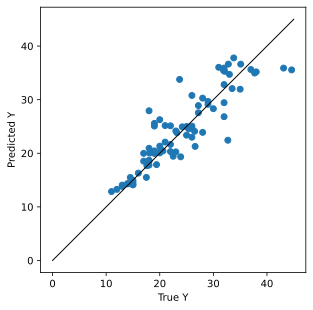

In [10]:
# Fit the black-box model on all data points
black_box.fit(X_data, Y_data)

# Make predictions on test data
Y_hat = black_box.predict(X_test)

# Compare test points to predicted values
plt.plot([0, 45], [0, 45], color = 'black', linewidth = 1)
plt.scatter(Y_test, Y_hat)
plt.axis('square')
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.show()

## Naive prediction intervals based on in-sample residuals

In [11]:
def naive_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute naive prediction bands based on the distribution of
      residuals within the training data set
      
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Fit the black box model on the training data
    black_box.fit(X, Y)
    
    # Compute residuals on the training data
    residuals_calib = np.abs(Y - black_box.predict(X))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

In [12]:
def evaluate_predictions(lower, upper, X, Y, verbose=True):
    """
    Evaluate performance metrics for a set of regression predictions
    Computes:
    - marginal coverage
    - average size of sets
    
    Input
    lower     : n x 1 vector of prediction lower bounds
    upper     : n x 1 vector of prediction upper upper
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    """
    
    # Number of samples
    n = len(Y)
    
    # Evaluate the empirical coverage
    covered = (Y>=lower) * (Y <= upper)

    # Compute marginal coverage
    marginal_coverage = np.mean(covered)
    
    # Compute average size of prediction sets
    size = np.mean(upper-lower)
    
    # Compute average size of prediction sets that contain the true label
    idx_cover = np.where(covered)[0]
    size_cover = np.mean(upper[idx_cover]-lower[idx_cover])
    
    # Print summary
    if verbose:
        print('Marginal coverage       : {:2.3%}'.format(marginal_coverage))
        print('Average length          : {:2.3f}'.format(size))
        
    return marginal_coverage, size

In [13]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 55.696%
Average length          : 3.502


## Conformal prediction via conditional mean regression

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Choose a black-box machine learning model (1,2,3,4)
bb_model_index = 1

if bb_model_index==1:
    # Random forest
    black_box = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=2023)
elif bb_model_index==2:
    # Random forest with more aggressive splits
    black_box = RandomForestRegressor(n_estimators=10, min_samples_split=1, random_state=2023)
elif bb_model_index==3:
    # Support vector machine
    black_box = SVR(kernel='rbf', degree=3)
elif bb_model_index==4:
    # Neural network
    black_box = MLPRegressor(hidden_layer_sizes=(200,), max_iter=1000, random_state=2023)
else:
    print("Error: unknown machine learning model")
    black_box = None

In [15]:
def conformal_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=random_state)
    
    # Fit the black box model on the training data
    black_box.fit(X_train, Y_train)
    
    # Compute residuals on the calibration data
    residuals_calib = np.abs(Y_calib - black_box.predict(X_calib))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

In [16]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 86.076%
Average length          : 9.364


## Cross-validation+

In [17]:
from sklearn.model_selection import KFold
import copy

def cv_prediction_intervals(X, Y, X_test, black_box, alpha, K, random_state=2023):
    """
    Compute CV+ version of quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X            : n x p data matrix of explanatory variables
    Y            : n x 1 vector of response variables
    X_test       : n x p test data matrix of explanatory variables
    black_box    : sklearn model object with 'fit' and 'predict' methods
    alpha        : 1 - target coverage level 
    K            : number of folds
    random_state : random seed for replicability (default: 2023)
    """
    
    # Number of data points
    n = X.shape[0]
    
    # Number of test points
    n_test = X_test.shape[0]
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    # Make list of test indices for each fold
    calibration_indices = [calib_index for _, calib_index in cv.split(X)]
    
    # Make list of folds for each individual
    # That is, fold[i] = k(i) in the notation from the slides
    fold = np.zeros(n).astype(int)
    for k in range(K):
        fold[calibration_indices[k]] = k
    
    # Fit K models, one for each fold
    q_hat = [ copy.deepcopy(black_box.fit(X[train_index], Y[train_index])) 
             for train_index, _ in cv.split(X) ]
    
    # Compute conformity scores on hold-out data for each fold
    Z = np.zeros(len(Y))
    for k in range(K):
        
        # List of calibration points for this fold
        idx_calib = None # This should be a vector of indices corresponding to the hold-out points
        """TODO: write your code here (1 lines)"""
        
        # Evaluate point predictions for hold-out data
        y_hat = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (2 lines)"""
        
        # Compute conformity scores for this fold
        Z_fold = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (1 line)"""
        
        # Store the conformity scores for this fold
        Z[idx_calib] = Z_fold
       
    # Compute upper limit of prediction intervals for each test point (one at a time)
    lower = np.zeros(n_test)
    upper = np.zeros(n_test)
        
    for j in range(n_test):
        # Evaluate point predictions for hold-out data
        y_hat = np.zeros(n)
        
        for k in range(K):
            # Which data points were hold-out in this fold?
            idx_calib = None # This should be a vector of indices corresponding to the hold-out points
            """TODO: write your code here (1 lines)"""
            
            # Evaluate point predictions for hold-out data
            y_hat = None # This should be a vector of the same length as idx_calib
            """TODO: write your code here (1 line)"""
            
        # CV+ upper limit for this point
        upper[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
        
        # CV+ lower limit for this point
        lower[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
    
    return lower, upper 

In [20]:
def cv_prediction_intervals(X, Y, X_test, black_box, alpha, K, random_state=2023):
    """
    Compute CV+ conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    K            : number of folds
    """
    
    # Number of data points
    n = X.shape[0]
    
    # Number of test points
    n_test = X_test.shape[0]
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    # Make list of test indices for each fold
    calibration_indices = [calib_index for _, calib_index in cv.split(X)]
    
    # Make list of folds for each individual
    # That is, fold[i] = k(i) in the notation from the slides
    fold = np.zeros(n).astype(int)
    for k in range(K):
        fold[calibration_indices[k]] = k
    
    # Fit K models, one for each fold
    q_hat = [ copy.deepcopy(black_box.fit(X[train_index], Y[train_index])) 
             for train_index, _ in cv.split(X) ]
    
    # Compute conformity scores on hold-out data for each fold
    Z = np.zeros(len(Y))
    for k in range(K):
        
        # List of calibration points for this fold
        idx_calib = calibration_indices[k]
        
        # Evaluate point predictions
        y_hat = q_hat[k].predict(X[idx_calib])
        
        # Compute conformity scores for this fold
        Z_fold = np.abs(Y[idx_calib] - y_hat)
        
        # Store the conformity scores for this fold
        Z[idx_calib] = Z_fold
       
    # Compute upper limit of prediction intervals for each test point (one at a time)
    lower = np.zeros(n_test)
    upper = np.zeros(n_test)
        
    for j in range(n_test):
        # Evaluate point predictions for hold-out data
        y_hat = np.zeros(n)
        
        for k in range(K):
            # Which data points were hold-out in this fold?
            idx_calib = calibration_indices[k]
            
            # Evaluate point predictions for hold-out data
            y_hat[idx_calib] = q_hat[k].predict(X_test[j:(j+1)])
                                        
        # CV+ upper limit for this point
        percentile_upper = (1.0-alpha)*(1.0+1.0/float(n))
        upper[j] = mquantiles(y_hat + Z, prob=percentile_upper)[0]
        
        # CV+ lower limit for this point
        percentile_lower = alpha*(1.0+1.0/float(n))
        lower[j] = mquantiles(y_hat - Z, prob=percentile_lower)[0]
    
    return lower, upper 

In [21]:
# Apply CV+
K = 10
lower, upper = cv_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, K)

# Evaluate performance
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 84.810%
Average length          : 9.216


## Numerical experiments

We will now repeatedly apply the two methods described above to the data set, each time using a different random subset of the data for testing.

In [22]:
def run_experiment_cv(dataset, K, random_state=2023):
    # Divide data
    X_data, X_test, Y_data, Y_test = train_test_split(dataset[:,1:-1], dataset[:,0], 
                                                      test_size=0.2, random_state=random_state)
    
    # Run and evaluate split conformal CQR
    lower_sc, upper_sc = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, random_state=random_state)
    metrics_sc = evaluate_predictions(lower_sc, upper_sc, X_test, Y_test, verbose=False)
    
    # Run and evaluate CV+
    lower_cv, upper_cv = cv_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, K, random_state=random_state)
    metrics_cv = evaluate_predictions(lower_cv, upper_cv, X_test, Y_test, verbose=False)
    
    # Return results
    results_exp = pd.DataFrame({"Method":["Split", "CV+"], 
                                "Coverage":[metrics_sc[0], metrics_cv[0]],
                                "Length":[metrics_sc[1], metrics_cv[1]],
                  })
    return results_exp

In [23]:
# Run many experiments
results_cv = pd.DataFrame()

from tqdm import tqdm

for experiment in tqdm(range(50)):
    
    # Random state for this experiment
    random_state = 2023 + experiment
    
    # Run the experiment
    
    result_exp = run_experiment_cv(dataset, K=10, random_state=random_state)
    
    # Store results
    results_cv = pd.concat([results_cv,result_exp])

100%|███████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


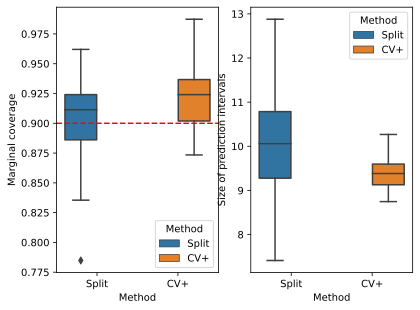

In [24]:
# Compare marginal coverage
plt.subplot(1, 2, 1)
ax = sns.boxplot(y="Coverage", x="Method", hue="Method", data=results_cv)
ax.set(xlabel='Method', ylabel='Marginal coverage')
ax.axhline(1-alpha, ls='--', color="red")

# Compare average length of prediction intervals
plt.subplot(1, 2, 2)
ax = sns.boxplot(y="Length", x="Method", hue="Method", data=results_cv)
ax.set(xlabel='Method', ylabel='Size of prediction intervals')
plt.show()

## Conformal prediction via quantile regression

Alternatively, we already know how to construct predictive intervals with valid marginal coverage using CQR.

In [25]:
# Choose a black-box quantile regression model (1 or 2)
bb_qr_model_index = 2

alpha = 0.1

if bb_qr_model_index==1:
    # Random forest
    black_box_qr = qr.LinearQR(alpha=0.1)
elif bb_qr_model_index==2:
    black_box_qr = qr.RFQR(alpha=0.1, n_estimators=10)
else:
    print("Error: unknown quantile regression model")
    black_box_qr = None

In [26]:
def cqr_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : quantile regression model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=random_state)
    
    # Fit the quantile regression model
    black_box.fit(X_train, Y_train)

    # Estimate conditional quantiles for calibration set
    lower, upper = black_box.predict(X_calib)
    
    # Compute conformity scores on the calibration data
    residuals_calib = np.maximum(Y_calib - upper, lower - Y_calib)
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    lower, upper = black_box.predict(X_test)
    lower = lower - Q_hat
    upper = upper + Q_hat
    
    return lower, upper 

In [27]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply quantile regression split conformal
lower, upper = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha)

# Evaluate performance of predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 78.481%
Average length          : 9.273


## CV+ conformal quantile regression (optional homework)

Next, we will apply CQR with CV+ data hold out instead of split-conformal.
This is slighly more involved.

In [28]:
from sklearn.model_selection import KFold
import copy

def cv_cqr_prediction_intervals(X, Y, X_test, alpha, K, random_state=2023):
    """
    Compute CV+ version of quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X            : n x p data matrix of explanatory variables
    Y            : n x 1 vector of response variables
    X_test       : n x p test data matrix of explanatory variables
    alpha        : 1 - target coverage level 
    K            : number of folds
    random_state : random seed for replicability (default: 2023)
    """
    
    # Number of data points
    n = X.shape[0]
    
    # Number of test points
    n_test = X_test.shape[0]
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    # Make list of test indices for each fold
    calibration_indices = [calib_index for _, calib_index in cv.split(X)]
    
    # Make list of folds for each individual
    # That is, fold[i] = k(i) in the notation from the slides
    fold = np.zeros(n).astype(int)
    for k in range(K):
        fold[calibration_indices[k]] = k
    
    # Fit K models, one for each fold
    q_hat = None # This should be a list of K properly trained black-box objects
    """TODO: write your code here (2 lines)"""
    
    # Compute conformity scores on hold-out data for each fold
    Z = np.zeros(len(Y))
    for k in range(K):
        
        # List of calibration points for this fold
        idx_calib = None # This should be a vector of indices corresponding to the hold-out points
        """TODO: write your code here (1 lines)"""
        
        # Evaluate hold-out estimates of lower and upper conditional quantiles
        lower_estim = None # This should be a vector of the same length as idx_calib
        upper_estim = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (2 lines)"""
        
        # Compute conformity scores for this fold
        Z_fold = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (1 line)"""
        
        # Store the conformity scores for this fold
        Z[idx_calib] = Z_fold
       
    # Compute upper limit of prediction intervals for each test point (one at a time)
    lower = np.zeros(n_test)
    upper = np.zeros(n_test)
        
    for j in range(n_test):
        # Evaluate estimates of conditional quantiles
        lower_estim = np.zeros(n)
        upper_estim = np.zeros(n)
        
        for k in range(K):
            # Which data points were hold-out in this fold?
            idx_calib = None # This should be a vector of indices corresponding to the hold-out points
            """TODO: write your code here (1 lines)"""
            
            # Evaluate hold-out estimates of lower and upper conditional quantiles
            lower_estim = None # This should be a vector of the same length as idx_calib
            upper_estim = None # This should be a vector of the same length as idx_calib
            """TODO: write your code here (2 lines)"""
            
        # CV+ upper limit for this point
        upper[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
        
        # CV+ lower limit for this point
        lower[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
    
    return lower, upper 

In [29]:
from sklearn.model_selection import KFold
import copy
import pdb

def cv_cqr_prediction_intervals(X, Y, X_test, alpha, K, random_state=2023):
    """
    Compute CV+ version of quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X            : n x p data matrix of explanatory variables
    Y            : n x 1 vector of response variables
    X_test       : n x p test data matrix of explanatory variables
    alpha        : 1 - target coverage level 
    K            : number of folds
    random_state : random seed for replicability (default: 2023)
    """
    
    # Number of data points
    n = X.shape[0]
    
    # Number of test points
    n_test = X_test.shape[0]
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    # Make list of test indices for each fold
    calibration_indices = [calib_index for _, calib_index in cv.split(X)]
    
    # Make list of folds for each individual
    # That is, fold[i] = k(i) in the notation from the slides
    fold = np.zeros(n).astype(int)
    for k in range(K):
        fold[calibration_indices[k]] = k
    
    # Fit K models, one for each fold
    black_box = qr.RFQR(alpha=alpha, n_estimators=10)
    q_hat = [ copy.deepcopy(black_box.fit(X[train_index], Y[train_index])) 
             for train_index, _ in cv.split(X) ]
    
    # Compute conformity scores on hold-out data for each fold
    Z = np.zeros(len(Y))
    for k in range(K):
        
        # List of calibration points for this fold
        idx_calib = calibration_indices[k]
        
        # Evaluate estimates of conditional quantiles
        lower_estim, upper_estim = q_hat[k].predict(X[idx_calib])
        
        # Compute conformity scores for this fold
        Z_fold = np.maximum(Y[idx_calib] - upper_estim, lower_estim - Y[idx_calib])
        
        # Store the conformity scores for this fold
        Z[idx_calib] = Z_fold
       
    # Compute upper limit of prediction intervals for each test point (one at a time)
    lower = np.zeros(n_test)
    upper = np.zeros(n_test)
        
    for j in range(n_test):
        # Evaluate estimates of conditional quantiles
        lower_estim = np.zeros(n)
        upper_estim = np.zeros(n)
        
        for k in range(K):
            # Which data points were hold-out in this fold?
            idx_calib = calibration_indices[k]
            
            # Evaluate hold-out estimates of lower and upper conditional quantiles
            lower_estim[idx_calib],upper_estim[idx_calib] = q_hat[k].predict(X_test[j:(j+1)])
                                        
        # CV+ upper limit for this point
        percentile_upper = (1.0-alpha)*(1.0+1.0/float(n))
        upper[j] = mquantiles(upper_estim + Z, prob=percentile_upper)[0]
        
        # CV+ lower limit for this point
        percentile_lower = alpha*(1.0+1.0/float(n))
        lower[j] = mquantiles(lower_estim - Z, prob=percentile_lower)[0]
    
    
    return lower, upper 

In [30]:
# Apply quantile regression with CV+
K = 10
lower, upper = cv_cqr_prediction_intervals(X_data, Y_data, X_test, alpha, K)

# Evaluate performance
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 89.873%
Average length          : 10.262


## Numerical experiments (quantile regression)

We will now repeatedly apply the two methods described above to the data set, each time using a different random subset of the data for testing.

In [31]:
def run_experiment(dataset, K, random_state=2023):
    # Divide data
    X_data, X_test, Y_data, Y_test = train_test_split(dataset[:,1:-1], dataset[:,0], 
                                                      test_size=0.2, random_state=random_state)
    
    # Run and evaluate split conformal CQR
    lower_sc, upper_sc = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha, random_state=random_state)
    metrics_sc = evaluate_predictions(lower_sc, upper_sc, X_test, Y_test, verbose=False)
    
    # Run and evaluate CV+ CQR
    lower_cv, upper_cv = cv_cqr_prediction_intervals(X_data, Y_data, X_test, alpha, K, random_state=random_state)
    metrics_cv = evaluate_predictions(lower_cv, upper_cv, X_test, Y_test, verbose=False)
    
    # Return results
    results_exp = pd.DataFrame({"Method":["Split", "CV+"], 
                                "Coverage":[metrics_sc[0], metrics_cv[0]],
                                "Length":[metrics_sc[1], metrics_cv[1]],
                  })
    return results_exp

In [ ]:
# Run many experiments
results = pd.DataFrame()

from tqdm import tqdm

for experiment in tqdm(range(50)):
    
    # Random state for this experiment
    random_state = 2023 + experiment
    
    # Run the experiment
    
    result_exp = run_experiment(dataset, K=10, random_state=random_state)
    
    # Store results
    results = pd.concat([results,result_exp])

  8%|███▌                                        | 4/50 [00:02<00:34,  1.34it/s]

In [ ]:
# Compare marginal coverage
plt.subplot(1, 2, 1)
ax = sns.boxplot(y="Coverage", x="Method", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Marginal coverage')
ax.axhline(1-alpha, ls='--', color="red")

# Compare average length of prediction intervals
plt.subplot(1, 2, 2)
ax = sns.boxplot(y="Length", x="Method", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Size of prediction intervals')
plt.show()